In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import scipy.special as sp
import seaborn as sns
import scipy.optimize as opt

1. Реализовать сложные критерий Колмогорова для проверки принадлежности нормальному закону, используя метод Монте-Карло для вычисления предельного распределения p-value. Построить ЭФР p-value при гипотезе и при альтернативе, моделируя данные из распределения Стьюдента t5.

In [2]:
#подсчет статистики Колмогорова
def kolm(X):
	n=len(X)
	Y=st.norm.cdf(np.sort(X),loc=np.mean(X),scale=np.std(X))
	maxim=Y[0]
	for i in range(1,n-1):
		k=i/n
		left=abs(k-Y[i])
		right=abs(k-Y[i+1])
		maxim=np.max([maxim,left,right])
	maxim=max([maxim,1-Y[n-1]])
	return n**0.5*maxim

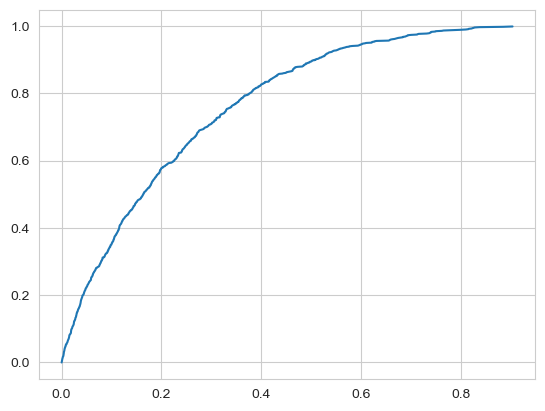

In [3]:
pvals=[]
for i in range(1000):
	X=np.random.normal(size=1000,loc=0,scale=1)
	k=kolm(X)
	c=sp.kolmogorov(k)
	pvals.append(1-c)
plt.plot(np.sort(pvals),[i/1000 for i in range(1000)])
None

In [4]:
def counter(t,T):
	for i in range(len(T)):
		if t>T[len(T)-1-i]:
			return i/len(T)
	return 1

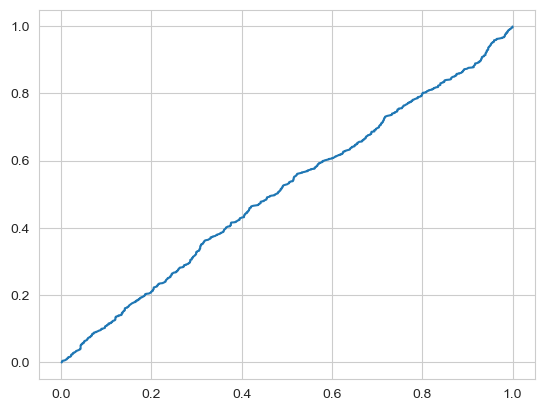

In [5]:
pvals1=[]
for i in range(1000):
	X=st.norm.rvs(size=1000,loc=6,scale=3)
	k=kolm(X)
	c=sp.kolmogorov(k)
	c=float(c)
	d=counter(1-c,np.sort(pvals))
	pvals1.append(d)
plt.plot(np.sort(pvals1),[i/1000 for i in range(1000)])
None

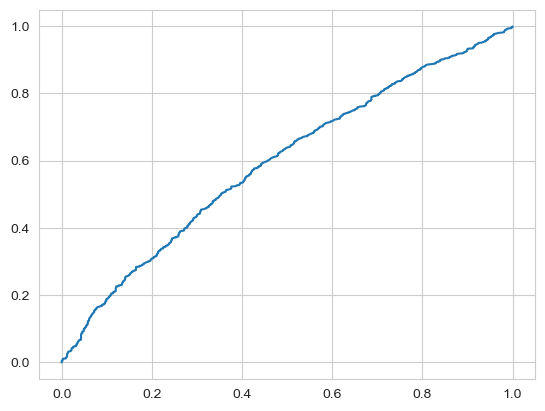

In [6]:
pvals1=[]
for i in range(1000):
	X=st.t.rvs(size=1000,df=25)
	k=kolm(X)
	c=sp.kolmogorov(k)
	c=float(c)
	pvals1.append(counter(1-c,np.sort(pvals)))
plt.plot(np.sort(pvals1),[i/1000 for i in range(1000)])
None

2. Реализовать критерий хи-квадрат для проверки нормальности. Для разбиения на промежутки использовать следующие подходы: 1) делим так, чтобы в ячейки попадало поровну наблюдений, 2) берем квантили уровней i/k теоретического распределения, в качестве неизвестного параметра используем ОМП. Для подсчета p-value использовать предельное распределение.

In [7]:
def quantiles_porovnu(X,k):#выдает вероятности попадания в отрезки, в которые попало одинаковое число элементов выборки
	X=np.sort(X)
	c=1
	doli=[]
	for i in range(len(X)):
		if i==int(round(len(X)*c/k)):
			doli.append(i)
			c+=1
	return [X[i] for i in doli],doli

In [8]:
def pravdopodobie(quantiles,mean,sd):
	p=pi(quantiles,mean,sd)
	result=1
	for i in p:
		result*=i
	return result

In [9]:
def pi(quantiles,mean,sd):
	p=[st.norm.cdf(quantiles[0],loc=mean,scale=sd)]
	for i in range(1,len(quantiles)):
		p.append(st.norm.cdf(quantiles[i],loc=mean,scale=sd)-st.norm.cdf(quantiles[i-1],loc=mean,scale=sd))
	p.append(1-st.norm.cdf(quantiles[len(quantiles)-1],loc=mean,scale=sd))
	return p

In [35]:
n=10000
k=int(round(n**0.2))
pvals=[]
stats=[]
for c in range(1000):
	X=np.random.normal(size=n,loc=3,scale=2)
	mean=np.mean(X)
	sd=np.std(X)
	quant,doli=quantiles_porovnu(X,k)
	doles=[doli[0]]
	for i in range(1,len(doli)):
		doles.append(doli[i]-doli[i-1])
	doles.append(n-doli[len(doli)-1])
	p=opt.minimize(lambda params: -pravdopodobie(quant,params[0],params[1]),x0=[mean,sd],bounds=((mean-3,mean+3),(sd/2,sd*3/2))).x
	p=pi(quant,p[0],p[1])
	stat=0
	for i in range(len(doles)):
		stat+=(doles[i]-n*p[i])**2/(n*p[i])
	pvals.append(1-st.chi2.cdf(stat,df=k-2))
	stats.append(stat)

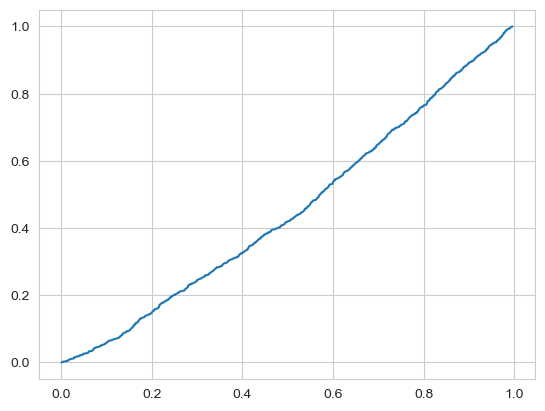

In [36]:
plt.plot(np.sort(pvals),np.linspace(0,1,1000))

In [33]:
n=2000
k=int(round(n**0.2))
print(k)
pvals=[]
stats=[]
for c in range(1000):
	X=st.laplace.rvs(size=n,loc=0,scale=1)
	mean=np.mean(X)
	sd=np.std(X)
	quant,doli=quantiles_porovnu(X,k)
	doles=[doli[0]]
	for i in range(1,len(doli)):
		doles.append(doli[i]-doli[i-1])
	doles.append(n-doli[len(doli)-1])
	p=opt.minimize(lambda params: -pravdopodobie(quant,params[0],params[1]),x0=[mean,sd],bounds=((mean-3,mean+3),(sd/2,sd*3/2))).x
	p=pi(quant,p[0],p[1])
	stat=0
	for i in range(len(doles)):
		stat+=(doles[i]-n*p[i])**2/(n*p[i])
	pvals.append(1-st.chi2.cdf(stat,df=k-2))
	stats.append(stat)

5


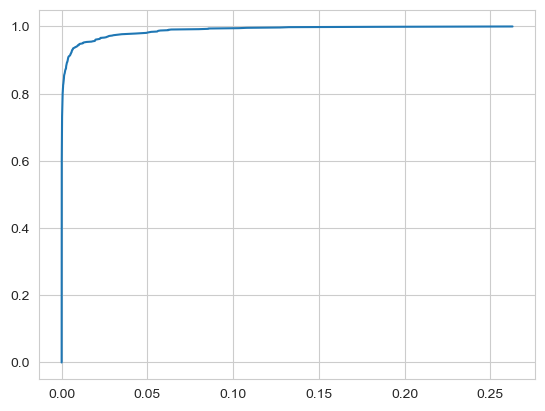

In [34]:
plt.plot(np.sort(pvals),np.linspace(0,1,1000))

In [51]:
def quants(x):
	k=int(round(len(x)**0.2))
	mean=np.mean(x)
	sd=np.std(x)
	quants=[]
	for i in range(1,k):
		quants.append(st.norm.ppf(i/k,loc=mean,scale=sd))
	return [min(x)-1]+quants+[max(x)+1]

In [52]:
def counts(x,minimum,maximum):
	counter=0
	for i in range(len(x)):
		if minimum<x[i]<=maximum:
			counter+=1
	return counter

In [57]:
pvals=[]
for i in range(500):
	x=np.random.normal(size=100000,loc=3,scale=4)
	k=int(round(len(x)**0.2))
	quantiles=quants(x)
	nus=[]
	for i in range(len(quantiles)-1):
		nus.append(counts(x,quantiles[i],quantiles[i+1]))
	pvals.append(st.chisquare(nus,[100000/k]).pvalue)

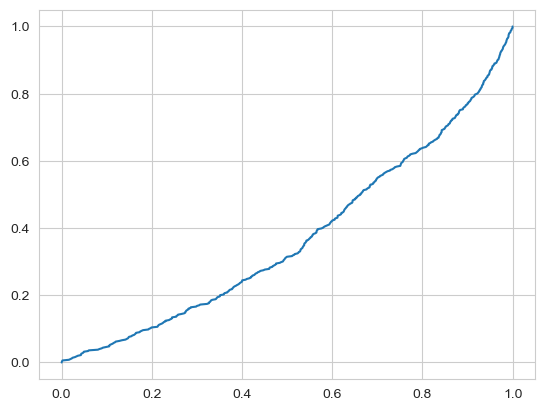

In [58]:
plt.plot(np.sort(pvals),np.linspace(0,1,500))

In [67]:
pvals=[]
for i in range(1000):
	x=np.random.laplace(size=100,loc=3,scale=4)
	k=int(round(len(x)**0.2))
	quantiles=quants(x)
	nus=[]
	for i in range(len(quantiles)-1):
		nus.append(counts(x,quantiles[i],quantiles[i+1]))
	pvals.append(st.chisquare(nus,[100/k]).pvalue)

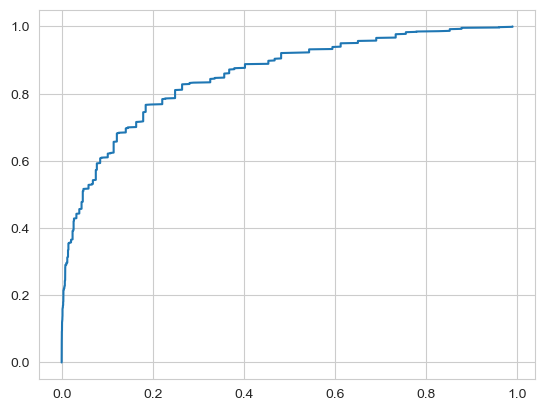

In [68]:
plt.plot(np.sort(pvals),np.linspace(0,1,1000))

3. Исследовать сгенерированные модельные данные X на нормальность, где
• Xi имеют распределение Вейбулла с параметром формы λ;
• Xi имеют χ2n распределение, n = 5, 10, 25
• Xi ∼ Binom(n, 1/2).
Использовать критерий из первого пункта. Построить ЭФР p-value и график мощности. Подобрать размер выборки так, чтобы сравнение было
осмысленным.

In [7]:
#подсчет статистики Колмогорова
def kolm(X):
	n=len(X)
	Y=st.norm.cdf(np.sort(X),loc=np.mean(X),scale=np.std(X))
	maxim=Y[0]
	for i in range(1,n-1):
		k=i/n
		left=abs(k-Y[i])
		right=abs(k-Y[i+1])
		maxim=np.max([maxim,left,right])
	maxim=max([maxim,1-Y[n-1]])
	return n**0.5*maxim

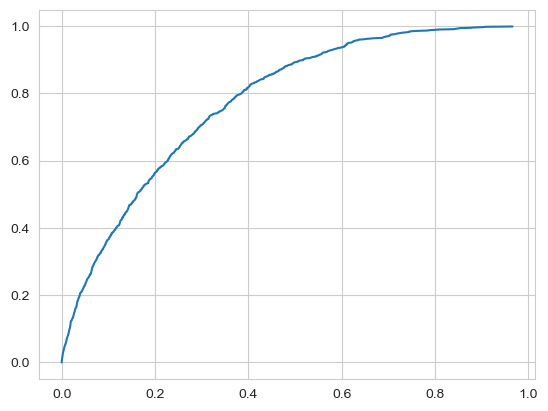

In [8]:
pvals=[]
for i in range(1000):
	X=np.random.normal(size=1000,loc=0,scale=1)
	k=kolm(X)
	c=sp.kolmogorov(k)
	pvals.append(1-c)
plt.plot(np.sort(pvals),[i/1000 for i in range(1000)])
None

In [9]:
def counter(t,T):
	for i in range(len(T)):
		if t>T[len(T)-1-i]:
			return i/len(T)
	return 1

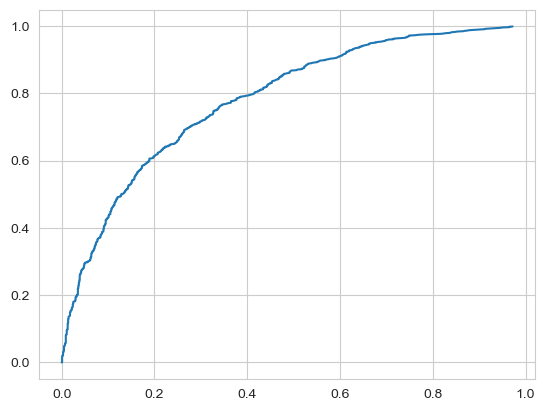

In [10]:
#Вейбулл
pvals1=[]
for i in range(1000):
	X=np.random.weibull(3,size=1000)
	k=kolm(X)
	c=sp.kolmogorov(k)
	c=float(c)
	d=counter(1-c,np.sort(pvals))
	pvals1.append(d)
plt.plot(np.sort(pvals1),[i/1000 for i in range(1000)])
None

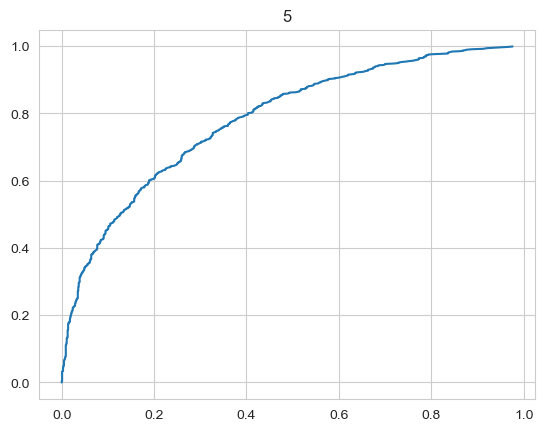

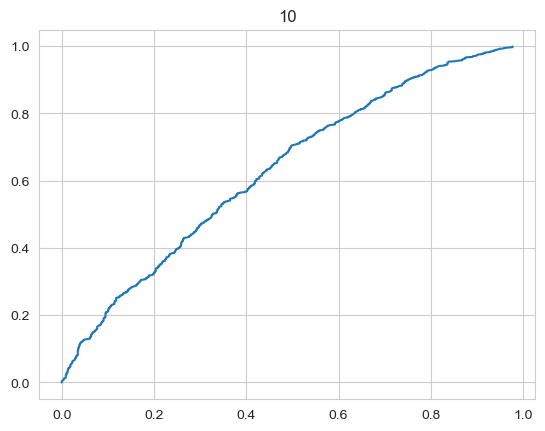

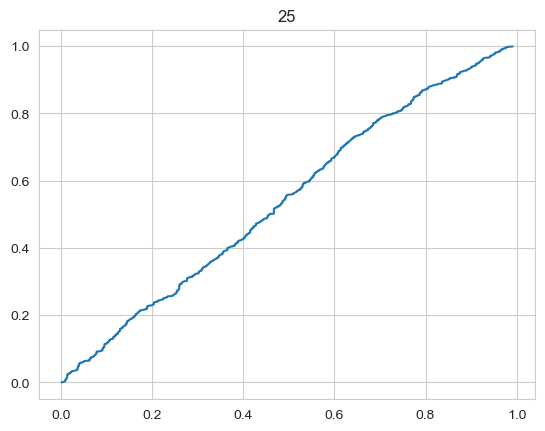

In [11]:
#хиквадрат
for j in [5,10,25]:
	pvals1=[]
	for i in range(1000):
		X=np.random.chisquare(j,size=50)
		k=kolm(X)
		c=sp.kolmogorov(k)
		c=float(c)
		d=counter(1-c,np.sort(pvals))
		pvals1.append(d)
	plt.plot(np.sort(pvals1),[i/1000 for i in range(1000)])
	plt.title(str(j))
	plt.show()
	None

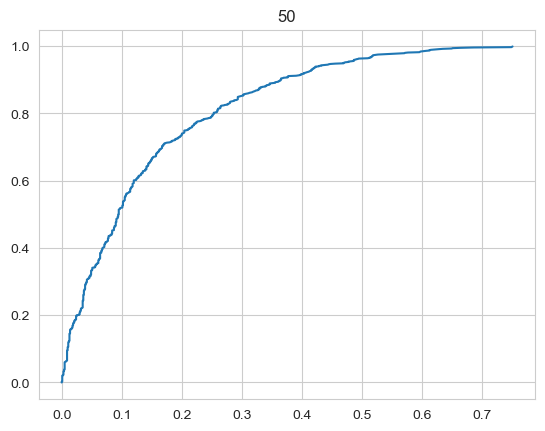

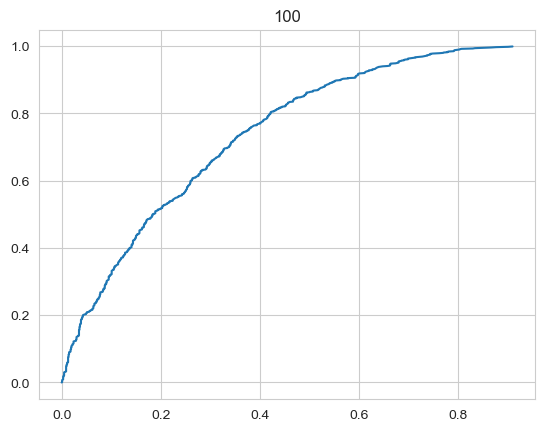

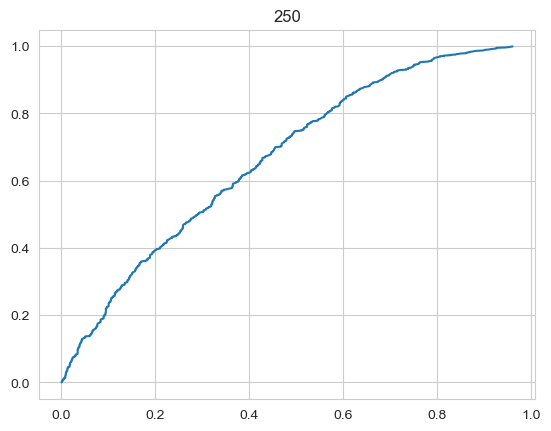

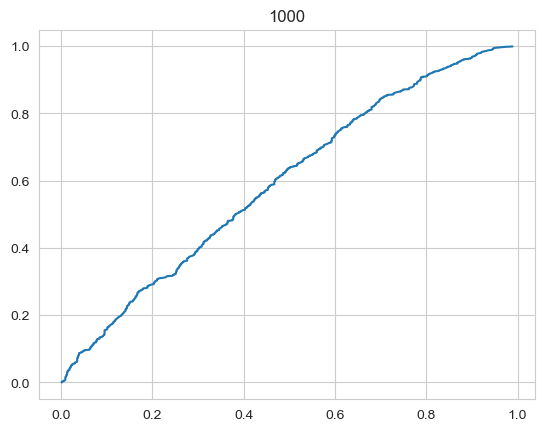

In [12]:
#бином
for j in [50,100,250,1000]:
	pvals1=[]
	for i in range(1000):
		X=np.random.binomial(n=j,p=0.5,size=50)
		k=kolm(X)
		c=sp.kolmogorov(k)
		c=float(c)
		d=counter(1-c,np.sort(pvals))
		pvals1.append(d)
	plt.plot(np.sort(pvals1),[i/1000 for i in range(1000)])
	plt.title(str(j))
	plt.show()
	None